In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from imodels import RuleFitClassifier
from IPython.core.display_functions import display
from rulevetting.projects.tbi_pecarn.dataset import Dataset as tbiDataset

def _get_x_y(ds):
    y_label = "outcome"
    y = np.squeeze(ds[y_label])
    X = ds.loc[:, ds.columns.drop(y_label)]
    return X, y

In [2]:
data = tbiDataset().get_data(run_perturbations=False, load_csvs=True, save_csvs=True)

In [3]:
X_train, y_train =  _get_x_y(data[0])
X_test, y_test =  _get_x_y(data[1])
feat_names = list(X_train.columns)

## Rule List

In [4]:
from imodels import RuleFitClassifier

# fit a rulefit model
rulefit = RuleFitClassifier(max_rules=6)
rulefit.fit(X_train, y_train)

# get test performance
preds = rulefit.predict_proba(X_test)[:, 1]
print(f'Test AUC: {metrics.roc_auc_score(y_test, preds):0.2f}')



Test AUC: 0.73


In [5]:
# inspect and print the rules
rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis'))

,rule,coef,support
41,AgeTwoPlus,-1.543825,1.000000
61,LOCSeparate_No,-0.121473,1.000000
120,SFxBasHem <= 0.5 and AMSSlow <= 0.5,-0.444580,0.964451
119,SFxPalp_No > 0.5 and SFxBasOto <= 0.5 and AMSAgitated <= 0.5,-0.372017,0.957616
118,SFxBasHem <= 0.5 and OSI <= 0.5 and Drugs <= 0.5,-0.090172,0.890054
117,SFxPalpDepress_Not applicable > 0.5 and AMS <= 0.5,-0.629596,0.867625


# Rule Set

In [6]:
from imodels import GreedyRuleListClassifier

m = GreedyRuleListClassifier()
m.fit(X_train, y=y_train)
probs = m.predict_proba(X_test)

# Trees

In [7]:
from imodels import FIGSClassifier

figs = FIGSClassifier(max_rules=10)
figs.fit(X_train, y_train, feature_names=feat_names)


FIGSClassifier(max_rules=10)

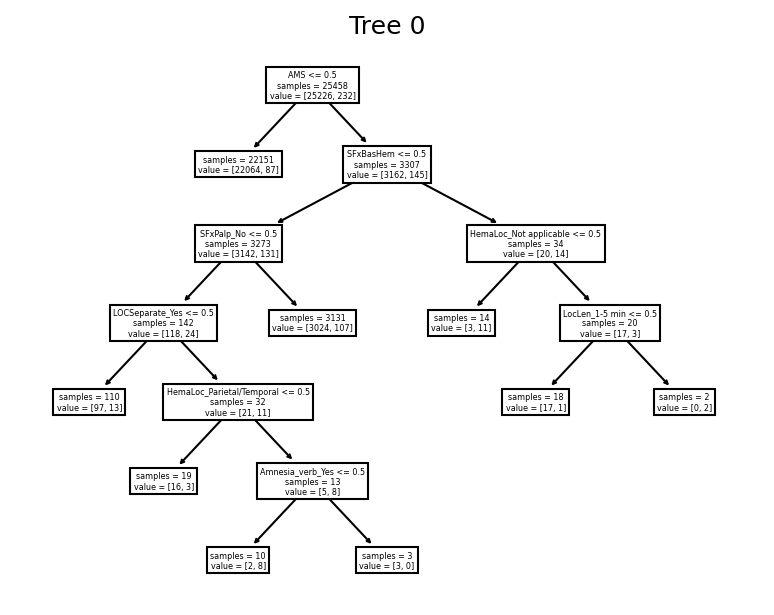

In [8]:
figs.plot(tree_number=0)

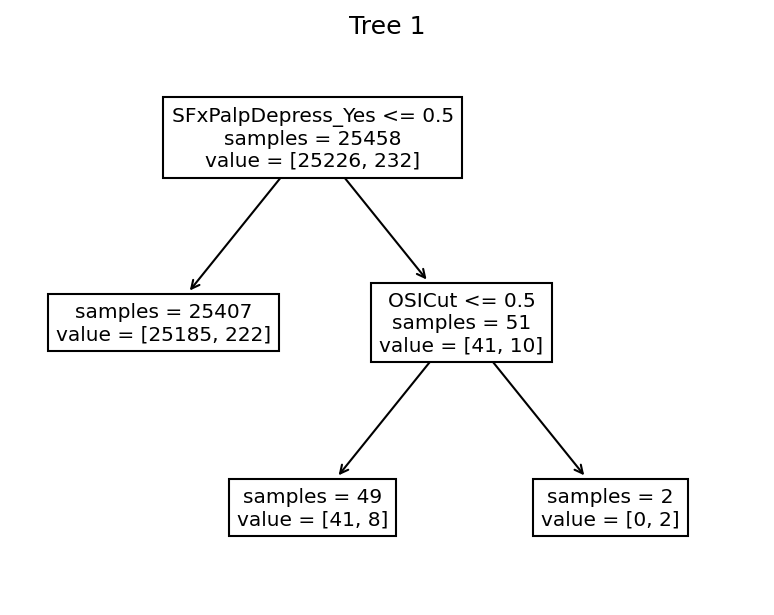

In [9]:
figs.plot(tree_number=1)

In [10]:
from imodels import HSTreeClassifierCV

model = HSTreeClassifierCV(max_leaf_nodes=4)  # initialize a tree model and specify only 4 leaf nodes
model.fit(X_train, y_train, feature_names=feat_names)   # fit model
preds = model.predict(X_test) # discrete predictions: shape is (n_test, 1)
preds_proba_hs = model.predict_proba(X_test) # predicted probabilities: shape is (n_test, n_classes)

/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warni

In [11]:
print(model) # print the model

> ------------------------------
> Decision Tree with Hierarchical Shrinkage
> 	Prediction is made by looking at the value in the appropriate leaf of the tree
> ------------------------------
|--- feature_5 <= 0.50
|   |--- weights: [1.00, 0.00] class: 0.0
|--- feature_5 >  0.50
|   |--- feature_13 <= 0.50
|   |   |--- weights: [0.96, 0.04] class: 0.0
|   |--- feature_13 >  0.50
|   |   |--- feature_110 <= 0.50
|   |   |   |--- weights: [0.22, 0.78] class: 1.0
|   |   |--- feature_110 >  0.50
|   |   |   |--- weights: [0.85, 0.15] class: 0.0



In [23]:
from imodels import GreedyTreeClassifier

model = GreedyTreeClassifier(max_leaf_nodes=4)  # initialize a tree model and specify only 4 leaf nodes
model.fit(X_train, y_train, feature_names=feat_names)   # fit model
preds = model.predict(X_test) # discrete predictions: shape is (n_test, 1)
preds_proba_cart = model.predict_proba(X_test) # predicted probabilities: shape is (n_test, n_classes)
print(model) # print the model

> ------------------------------
> Greedy CART Tree:
> 	Prediction is made by looking at the value in the appropriate leaf of the tree
> ------------------------------
|--- feature_5 <= 0.50
|   |--- weights: [22064.00, 87.00] class: 0.0
|--- feature_5 >  0.50
|   |--- feature_13 <= 0.50
|   |   |--- weights: [3142.00, 131.00] class: 0.0
|   |--- feature_13 >  0.50
|   |   |--- feature_18 <= 0.50
|   |   |   |--- weights: [17.00, 3.00] class: 0.0
|   |   |--- feature_18 >  0.50
|   |   |   |--- weights: [3.00, 11.00] class: 1.0



/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GreedyTreeClassifier was fitted without feature names
  warnings.warn(
/Users/omer/miniforge3/envs/rule-vetting/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GreedyTreeClassifier was fitted without feature names
  warnings.warn(


In [30]:
import pandas as pd
idx = preds_proba_cart[:, 1] > 0.004
pd.DataFrame({"CART":preds_proba_cart[idx, 1], "HS":preds_proba_hs[idx, 1]})

,CART,HS
0,0.040024,0.040024
1,0.040024,0.040024
2,0.040024,0.040024
3,0.040024,0.040024
4,0.040024,0.040024
...,...,...
1081,0.040024,0.040024
1082,0.040024,0.040024
1083,0.040024,0.040024
1084,0.040024,0.040024


In [27]:
preds_proba_cart[0, 1]

0.003927587919281297

In [28]:
preds_proba_hs[0, 1]


0.00392760828789099

In [ ]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(label='outcome')
predictor.fit(data[0], presets='interpretable')

In [8]:
predictor.leaderboard(data[1], silent=True)